In [1]:
PATH='/home/kirana/Documents/phd/experiment1_new/DNNREC_ML1M'
DATAPATH='/home/kirana/Documents/final_dissertation_final/experiments/datasets/ml-1m'

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import os
import pickle
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import pickle
from sklearn import metrics

In [3]:
[dftrain,dfvalid,results_concat]=pickle.load(open(f'{DATAPATH}/df_side_cold_runother.pkl','rb'))

In [4]:
df=pd.concat([dftrain,dfvalid[dftrain.columns]],axis=0)

In [5]:
user_to_idx={j:i+1 for i, j in enumerate(df['userId'].unique())}
item_to_idx={j:i+1 for i,j in enumerate(df['itemId'].unique())}
idx_to_user={i+1:j for i, j in enumerate(df['userId'].unique())}
idx_to_item={i+1:j for i,j in enumerate(df['itemId'].unique())}

In [6]:
dftrain['user_idx']=[user_to_idx[i] for i in dftrain['userId']]
dftrain['item_idx']=[item_to_idx[i] for i in dftrain['itemId']]

In [7]:
dfvalid['user_idx']=[user_to_idx[i] for i in dfvalid['userId']]
dfvalid['item_idx']=[item_to_idx[i] for i in dfvalid['itemId']]

In [8]:
pickle.dump([df, dftrain,dfvalid,idx_to_user,idx_to_item,item_to_idx,user_to_idx],open(f'{DATAPATH}/reads.pkl','wb'))

### Dataset and DataLoader

In [9]:
class cfdata (torch.utils.data.dataset.Dataset):
    def __init__(self,dfX,dfY):
        self.dfX,self.dfY=dfX,dfY
        
    def __len__ (self):
        return self.dfX.shape[0]
    
    def __getitem__ (self, idx):
        return torch.LongTensor(self.dfX.iloc[idx].values),torch.FloatTensor([self.dfY.values[idx]])

In [10]:
dstrain=cfdata(dftrain[['user_idx','item_idx']],dftrain['rating'])
dsvalid=cfdata(dfvalid[['user_idx','item_idx']],dfvalid['rating'])

In [11]:
dftrain.shape

(895738, 392)

In [12]:
bs=128

In [13]:
dltrain=DataLoader(dstrain,bs,True)

In [14]:
dlvalid=DataLoader(dsvalid,bs,False)

In [15]:
len(user_to_idx),len(item_to_idx)

(6040, 3706)

## Model Architecture

In [16]:
n_users=len(user_to_idx)
n_items=len(item_to_idx)
n_emb_user=50
n_emb_item=50
min_rating=min(dftrain['rating'])
max_rating=max(dftrain['rating'])
dropout_e=0.05


In [17]:
n_users

6040

In [18]:
class cf(nn.Module):    
    def __init__(self,n_users,n_emb_user,n_emb_item,n_items,min_rating,max_rating,dropout_e=0.01):
        super().__init__()
        self.n_users,self.n_emb_user,self.n_emb_item,self.n_items,self.min_rating,self.max_rating=\
                    n_users,n_emb_user,n_emb_item,n_items,min_rating,max_rating
        self.dropout_e=dropout_e
        self.create_architecture()
        self.init_parameters()
        self.criterion=nn.MSELoss()
        
        
    def create_architecture(self):
        self.emb_user=nn.Embedding(self.n_users+1,self.n_emb_user)
        self.emb_item=nn.Embedding(self.n_items+1,self.n_emb_item)
        self.emb_dropout=nn.Dropout(self.dropout_e)
        self.ub=nn.Embedding(self.n_users+1,1)
        self.ib=nn.Embedding(self.n_items+1,1)

        self.sigmoid=nn.Sigmoid()
        
        
    def init_parameters(self):
        nn.init.kaiming_normal_(self.emb_user.weight.data)
        nn.init.kaiming_normal_(self.emb_item.weight.data)
        nn.init.kaiming_normal_(self.ub.weight.data)
        nn.init.kaiming_normal_(self.ib.weight.data)

       
    def forward (self,Xb,Yb):               
        users=self.emb_dropout(self.emb_user(Xb[:,0]))
        items=self.emb_dropout(self.emb_item(Xb[:,1]))
        users_bias=self.emb_dropout(self.ub(Xb[:,0]))
        items_bias=self.emb_dropout(self.ib(Xb[:,1]))

        out=(users*items).sum(1)+users_bias.squeeze()+items_bias.squeeze()
        out=self.sigmoid(out)
        preds=out*(self.max_rating-self.min_rating)+self.min_rating
        preds=preds.view(-1,1)
        loss=self.criterion(preds,Yb)
        return preds,loss

In [19]:
n_users

6040

In [20]:
cfobj=cf(n_users,n_emb_user,n_emb_item,n_items,min_rating,max_rating,dropout_e)

In [21]:
cfobj

cf(
  (emb_user): Embedding(6041, 50)
  (emb_item): Embedding(3707, 50)
  (emb_dropout): Dropout(p=0.05)
  (ub): Embedding(6041, 1)
  (ib): Embedding(3707, 1)
  (sigmoid): Sigmoid()
  (criterion): MSELoss()
)

In [22]:
for Xb, Yb in dltrain:
    break

In [23]:
Xb.shape, Yb.shape

(torch.Size([128, 2]), torch.Size([128, 1]))

In [24]:
cfobj.forward(Xb,Yb)

(tensor([[1.2350],
         [1.8783],
         [1.5948],
         [1.1079],
         [4.7079],
         [3.1883],
         [4.9802],
         [4.9611],
         [4.2395],
         [2.3799],
         [4.5697],
         [1.6961],
         [3.2735],
         [2.1516],
         [1.8564],
         [4.2394],
         [2.0496],
         [2.8313],
         [4.6196],
         [1.1584],
         [1.1269],
         [1.5511],
         [1.1920],
         [4.8180],
         [1.3005],
         [1.5688],
         [4.3099],
         [3.7867],
         [2.5027],
         [4.9196],
         [4.5424],
         [2.7295],
         [4.3660],
         [4.3960],
         [4.8734],
         [3.6887],
         [4.0026],
         [3.6784],
         [3.6450],
         [1.8189],
         [2.2372],
         [4.2669],
         [1.6678],
         [4.9216],
         [2.2567],
         [4.1493],
         [3.4297],
         [1.0198],
         [3.6447],
         [1.7351],
         [2.4484],
         [3.1508],
         [2.

## Learner

In [46]:
class Learner():
    def __init__(self,model,optimizer,metric_fn,device,bptt=12,print_every=5,clip_val=None,\
                 cycle_mult=0,lr_decay=0.7,wd_mult=1.1,start_lr=2e-2, end_lr=5e-4,error_type="mse"):
        self.model,self.optimizer,self.metric_fn,self.device,self.print_every,self.bptt,self.losses,self.clip_val=\
            model,optimizer,metric_fn,device,print_every,bptt,[],clip_val
        self.n_epochs=1
        self.cycle_mult,self.lr_decay=cycle_mult,lr_decay
        self.wd_mult=wd_mult
        for param_group in self.optimizer.param_groups:
            self.start_lr=param_group['lr']
            self.start_wd=param_group['weight_decay']
        self.wd=self.start_wd
        self.lr=self.start_lr
        self.end_lr=end_lr
        self.n_epoch=0
        self.lrs=[1e-2,5e-3,1e-4,5e-4]
        self.preds,self.preds_valid,self.trainY,self.actual=[],[],[],[]
        self.ratio=self.end_lr/self.start_lr
        self.num_steps=self.cycle_mult
        self.reset_cycle=self.cycle_mult
        self.error_type=error_type
        self.scores=[]
        self.generate_scores=False
        
    def fit (self,Xb,Yb,mode_train=True):
        if mode_train:
            self.model.train()
        else:
            self.model.eval()
        
        #import pdb
        #pdb.set_trace()
        preds,loss=self.model(Xb,Yb)

     
        if mode_train:
            if 1==0:
                lr =self.lrs[torch.randint(0,4,(1,))]
                for param_group in self.optimizer.param_groups:
                    param_group['lr']=lr
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
        myloss=loss.item()
    
        
        with torch.no_grad():
            if self.error_type == "mse":
                acc=nn.L1Loss() (preds,Yb)
                myrmse=np.sqrt(myloss)
            else:
                acc=nn.MSELoss() (preds,Yb)
                myrmse=np.sqrt(acc.item())
            acc=acc.item()
                 
        if mode_train==False:
            if self.generate_scores:
                self.scores.append(preds.detach().cpu().numpy().flatten())
        del preds
        del loss
        
        if self.clip_val is not None:
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.clip_val)
        
        return myloss, acc, myrmse
    
    def lr_find (self,start_lr,end_lr,iterator,n_batch):
        losses,lrs=[],[]
        ratio=end_lr/start_lr
        num_steps=n_batch
        lr=start_lr
        for i in range(num_steps):            
            lr=lr*(end_lr/start_lr)**(1/num_steps)
            lrs.append(lr)
        self.lrs=lrs
        self.run_epoch(iterator,mode_train=True,lrs=lrs)
    
    def run_epoch(self,iterator,mode_train,lrs=None):
        epoch_loss,epoch_acc,i,k=0,0,0,0
        epoch_rmse=0

        for Xb,Yb in iterator:
            Xb=Xb.to(self.device)
            Yb=Yb.to(self.device)
            
            if lrs is not None:
                lr=lrs[k]
                for param_group in self.optimizer.param_groups:
                    param_group['lr']=lr 
            
            loss,acc,myrmse=self.fit(Xb,Yb,mode_train)
            
            if lrs is not None:
                self.losses.append(loss)

            epoch_loss+=loss
            epoch_acc+=acc
            epoch_rmse+=myrmse
            
            k=k+1
            if k%self.print_every == 0:
                if k:
                    print (f'Batch:{k} {epoch_loss/(k)}  ')  
                    torch.cuda.empty_cache()

        epoch_loss=epoch_loss/len(iterator)
        epoch_acc=epoch_acc/len(iterator)
        epoch_rmse=epoch_rmse/len(iterator)
            
        return epoch_loss,epoch_acc,epoch_rmse
    
    def plot_lrs(self, n_roll=1,ylim=None,xlim=None):
        import seaborn as sns
        ax=sns.lineplot(x=self.lrs,y=pd.Series(self.losses).rolling(n_roll).mean())
        ax.set_xscale('log')
        ax.set_ylabel('Loss')
        ax.set_xlabel('Learning Rate')
        if ylim is not None:
            plt.ylim(ylim)
        if xlim is not None:
            plt.xlim(xlim)

     
    def run_epochs(self,dltrain,dlvalid,n_epochs=1):              
        for epoch in range(n_epochs):                
            loss,acc,rmse=self.run_epoch(dltrain,True)

            lossv,accv,rmsev=self.run_epoch(dlvalid,mode_train=False)
           
            if self.error_type=="mse":
                loss_mse=loss
                loss_rmse=rmse
                loss_mae=acc
                lossv_mse=lossv
                lossv_rmse=rmsev
                lossv_mae=accv
                
            else:
                loss_mse=acc
                loss_rmse=rmse
                loss_mae=loss
                lossv_mse=accv
                lossv_rmse=rmsev
                lossv_mae=lossv
            
            print (f'Epoch:{epoch} Learning rate {self.lr} Weight Decay {self.wd} Train Loss:{loss} \
                Valid Loss:{lossv} Train RMSE:{loss_rmse} Valid RMSE:{lossv_rmse} Train MSE:{loss_mse} Valid MSE:{lossv_mse} \
                Train MAE:{loss_mae} Valid MAE:{lossv_mae}')

              
         
     
            if self.cycle_mult:
                if self.n_epoch==self.reset_cycle:
                    self.lr=self.start_lr
                    #self.wd=self.start_wd
                    self.reset_cycle*=self.cycle_mult
                    #reset_cycle=self.n_epoch+reset_cycle
                    self.n_epoch=0
                    self.ratio=self.end_lr/self.start_lr
                    self.num_steps=self.reset_cycle
                else:
                    #self.lr*=(self.lr_decay**self.n_epoch)  
                    #if self.n_epoch>1:
                    self.wd*=self.wd_mult
                    self.lr=self.lr*(self.end_lr/self.start_lr)**(1/self.num_steps)
                    self.n_epoch+=1
        

                
            for param_group in self.optimizer.param_groups:
                param_group['lr']=self.lr
                param_group['weight_decay']=self.wd
          
     

In [51]:
if 1==1:
    del cfobj
    torch.cuda.empty_cache()

NameError: name 'cfobj' is not defined

In [52]:
device='cuda:0'

In [53]:
cfobj=cf(n_users,n_emb_user,n_emb_item,n_items,min_rating,max_rating,dropout_e)

In [54]:
cfobj=cfobj.to(device)

In [55]:
cfobj

cf(
  (emb_user): Embedding(6041, 50)
  (emb_item): Embedding(3707, 50)
  (emb_dropout): Dropout(p=0.05)
  (ub): Embedding(6041, 1)
  (ib): Embedding(3707, 1)
  (sigmoid): Sigmoid()
  (criterion): MSELoss()
)

In [56]:
len(dltrain)

6998

In [57]:
wd=1e-5
optimizer=torch.optim.Adam(cfobj.parameters(),lr=5e-3,betas=(0.9,0.999), weight_decay=wd)
learner=Learner(cfobj,optimizer,None,device,0,25000,0.25,cycle_mult=0)

In [58]:
learner.lr_find(1e-5,1e-1,dltrain,len(dltrain))

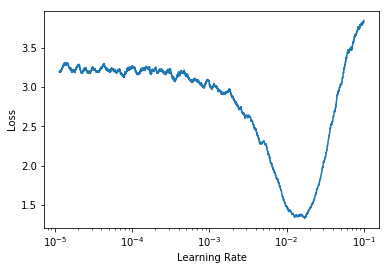

In [59]:
learner.plot_lrs(100)

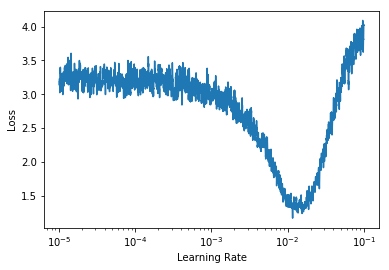

In [60]:
learner.plot_lrs(10)

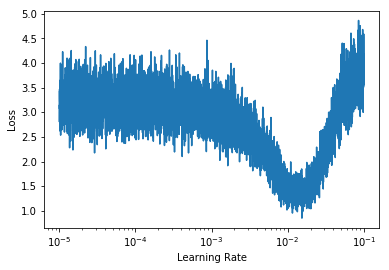

In [61]:
learner.plot_lrs(1)

In [71]:
del cfobj
torch.cuda.empty_cache()

In [72]:
wd

1e-05

In [73]:
wd=1e-5

In [74]:
cfobj=cf(n_users,n_emb_user,n_emb_item,n_items,min_rating,max_rating,dropout_e)
cfobj=cfobj.to(device)

In [75]:
device

'cuda:0'

In [76]:
cfobj

cf(
  (emb_user): Embedding(6041, 50)
  (emb_item): Embedding(3707, 50)
  (emb_dropout): Dropout(p=0.05)
  (ub): Embedding(6041, 1)
  (ib): Embedding(3707, 1)
  (sigmoid): Sigmoid()
  (criterion): MSELoss()
)

In [77]:
optimizer=torch.optim.Adam(cfobj.parameters(),lr=5e-3,betas=(0.9,0.999), weight_decay=wd)
learner=Learner(cfobj,optimizer,None,device,0,16000,0.25,cycle_mult=2,start_lr=5e-3,end_lr=1e-3,wd_mult=1.1)

In [78]:
learner.run_epochs(dltrain,dlvalid,7)

Epoch:0 Learning rate 0.005 Weight Decay 1e-05 Train Loss:1.2049506453913803                 Valid Loss:0.9114180172233862 Train RMSE:1.0739496824971415 Valid RMSE:0.9457800842136127 Train MSE:1.2049506453913803 Valid MSE:0.9114180172233862                 Train MAE:0.8502038677919589 Valid MAE:0.7531970597466173
Epoch:1 Learning rate 0.00223606797749979 Weight Decay 1.1000000000000001e-05 Train Loss:0.7039407708195831                 Valid Loss:0.8329640772088797 Train RMSE:0.8369727023027599 Valid RMSE:0.9035851572389015 Train MSE:0.7039407708195831 Valid MSE:0.8329640772088797                 Train MAE:0.6615636883232723 Valid MAE:0.7221848583863444
Epoch:2 Learning rate 0.001 Weight Decay 1.2100000000000003e-05 Train Loss:0.5923190937446983                 Valid Loss:0.8177869164885331 Train RMSE:0.7677680756694724 Valid RMSE:0.8951211778940756 Train MSE:0.5923190937446983 Valid MSE:0.8177869164885331                 Train MAE:0.6089968875361429 Valid MAE:0.7160031748810188
Epoch:3

In [79]:
learner.generate_scores=True

In [80]:
learner.run_epoch(dlvalid,False)

(0.8108393215782931, 0.713244564749182, 0.8915989892800735)

In [81]:
dfvalid['pred_cf']=np.concatenate(learner.scores)

In [82]:
np.sqrt(metrics.mean_squared_error(dfvalid['rating'],dfvalid['pred_cf']))

0.9004964103994674

In [83]:
def score_by_group (dfvalid,predVar,groupVar='cold_start_group',method='global_avg'):
    scores=[]
    mae_scores=[]
    rmse_scores=[]
    r2_scores=[]
    groups=dfvalid[groupVar].value_counts().index.tolist()
    for group in groups:
        df=dfvalid.loc[dfvalid[groupVar]==group]
        actual=df['rating']
        score=metrics.mean_squared_error(df['rating'],df[predVar])
        rmse_score=np.sqrt(metrics.mean_squared_error(df['rating'],df[predVar]))
        mae_score=metrics.mean_absolute_error(df['rating'],df[predVar])
        r2_score=metrics.r2_score(df['rating'],df[predVar])
        scores.append(score)
        mae_scores.append(mae_score)
        rmse_scores.append(rmse_score)
        r2_scores.append(r2_score)
    return pd.DataFrame({'method':method, 'mse':scores, 'rmse':rmse_scores, 'mae':mae_scores, 'r2_score':r2_scores, 'Cold Start Group':groups})

In [84]:
result_cf=pd.concat([score_by_group(dfvalid,'pred_cf','cold_start_group','cf'),score_by_group(dfvalid,'pred_cf','cold_start_bucket','cf'),\
score_by_group(dfvalid,'pred_cf','flag_train','cf')],axis=0)
result_cf

,method,mse,rmse,mae,r2_score,Cold Start Group
0,cf,0.785098,0.886058,0.699036,0.402302,No-cold-start
1,cf,1.076576,1.037582,0.859569,0.099582,User-Cold-Start
2,cf,0.752843,0.867665,0.715771,0.096589,Item-Cold_start
3,cf,2.000000,1.414214,1.000000,-1.000000,User-Item-cold-start
0,cf,0.785098,0.886058,0.699036,0.402302,0
1,cf,1.075937,1.037274,0.859227,0.100204,1
0,cf,0.810894,0.900496,0.713244,0.379590,0


In [85]:
mtx_user_emb=cfobj.emb_user.weight.data.cpu().numpy()
mtx_item_emb=cfobj.emb_item.weight.data.cpu().numpy()

In [86]:
user_bias_emb=cfobj.ub.weight.data.cpu().numpy()
item_bias_emb=cfobj.ib.weight.data.cpu().numpy()

In [87]:
mtx_user_emb.shape, mtx_item_emb.shape, user_bias_emb.shape, item_bias_emb.shape

((6041, 50), (3707, 50), (6041, 1), (3707, 1))

In [88]:
pickle.dump([mtx_user_emb,mtx_item_emb,user_bias_emb,item_bias_emb],open(f'{DATAPATH}/wts_embs_50','wb'))

In [89]:
results_concat.shape

(70, 6)

In [90]:
results_concat=pd.concat([results_concat,result_cf],axis=0)

In [91]:
pickle.dump([df,dftrain,dfvalid,idx_to_user,idx_to_item,item_to_idx,user_to_idx,results_concat],open(f'{DATAPATH}/df_side_cold_runother_cf_50.pkl','wb'))

In [92]:
results_concat

,method,mse,rmse,mae,r2_score,Cold Start Group
0,biasedmatrixfactorization,0.762661,0.873305,0.686658,0.419384,No-cold-start
1,biasedmatrixfactorization,0.975590,0.987719,0.787813,0.184044,User-Cold-Start
2,biasedmatrixfactorization,1.004593,1.002294,0.866920,-0.205512,Item-Cold_start
3,biasedmatrixfactorization,1.161611,1.077781,1.000000,-0.161611,User-Item-cold-start
0,biasedmatrixfactorization,0.762661,0.873305,0.686658,0.419384,0
1,biasedmatrixfactorization,0.975705,0.987778,0.788064,0.184027,1
0,biasedmatrixfactorization,0.781557,0.884057,0.695652,0.402036,0
0,svdplusplus,0.760565,0.872104,0.681210,0.420979,No-cold-start
1,svdplusplus,0.965663,0.982682,0.789363,0.192346,User-Cold-Start
2,svdplusplus,1.005146,1.002569,0.877412,-0.206175,Item-Cold_start
